# Building Conductance-based Neuron Models

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

In [2]:
bp.__version__

'2.3.0'

There are basically two types of neuron models: **conductance-based models** and **simplified models**. In conductance-based models, a single neuron can be regarded as a electric circuit, where the membrane is a capacitor, ion channels are conductors, and ion gradients are batteries. The neuronal activity is captured by the current flows through those ion channels. Sometimes there is an external input to this neuron, which can also be included in the equivalent circuit (see the figure below which shows potassium channels, sodium channels and leaky channels).

<img src="../_static/conductance_model_diagram.png" width="400 px">

On the other hand, simplified models do not care about the physiological features of neurons but mainly focus on how to reproduce the exact spike timing. Therefore, they are more simplified and maybe not biologically explicable.

BrainPy provides a large volume of [predefined neuron models](../apis/auto/dyn/neurons.rst) including conductance-based and simplified models for ease of use. In this section, we will only talk about how to build conductance-based models by ion channels. Users please refer to [Customizing Your Neuron Models](customize_neuron_models.ipynb) for more information.

## Building an ion channel

As we have known, ion channels are crucial for conductance-based neuron models. So how do we model an ion channel? Let's take a look at the potassium channel for instance.

<img src="../_static/potassium_channel_equivalent_circuit.png" width="500 px">

The diagram above shows how a potassium channel is changed to an electric circuit. By this, we have the differential equation:

$$
\begin{align}
c_\mathrm{M} \frac{\mathrm{d}V_\mathrm{M}}{\mathrm{d}t} &= \frac{E_\mathrm{K} - V_\mathrm{M}}{R_\mathrm{K}} \\
&= g_\mathrm{K}(E_\mathrm{K} - V_\mathrm{M}),
\end{align}
$$

in which $c_\mathrm{M}$ is the membrane capacitance, $\mathrm{d}V_\mathrm{M}$ is the membrane potential, $E_\mathrm{K}$ is the equilibrium potential of potassium ions, and $R_\mathrm{K}$ ($g_\mathrm{K}$) refers to the resistance (conductance) of the potassium channel. We define currents from inside to outside as the positive direction.

In the equation above, the conductance of potassium channels $g_\mathrm{K}$ does not remain a constant, but changes according to the membrane potential, by which the channel is categorized as **voltage-gated ion channels**. If we want to build an ion channel model, we should figure out how the conductance of the ion channel changes with membrane potential.

Fortunately, there has been a lot of work addressing this issue to formulate analytical expressions. For example, the conductance of one typical potassium channel can be written as:

$$
\begin{align}
g_\mathrm{K} &= \bar{g}_\mathrm{K} n^4, \\
\frac{\mathrm{d}n}{\mathrm{d}t} &= \phi [\alpha_n(V)(1-n) - \beta_n(V)n],
\end{align}
$$

in which $\bar{g}_\mathrm{K}$ refers to the maximal conductance and $n$, also named the gating variable, refers to the probability (proportion) of potassium channels to open. $\phi$ is a parameter showing the effects of temperature. In the differential equation of $n$, there are two parameters, $\alpha_n(V)$ and $\beta_n(V)$, that change with membrane potential:

$$
\begin{align}
\alpha_n(V) &= \frac{0.01(V+55)}{1 - \exp(-\frac{V+55}{10})}, \\
\beta_n(V) &= 0.125 \exp\left(-\frac{V+65}{80}\right).
\end{align}
$$

Now we have learned the mathematical expression of the potassium channel. Next, we try to build this channel in BrainPy.

In [3]:
class IK(bp.dyn.Channel):
  def __init__(self, size, E=-77., g_max=36., phi=1., method='exp_auto'):
    super(IK, self).__init__(size)
    self.g_max = g_max
    self.E = E
    self.phi = phi

    self.n = bm.Variable(bm.zeros(size))  # variables should be packed with bm.Variable
    
    self.integral = bp.odeint(self.dn, method=method)

  def dn(self, n, t, V):
    alpha_n = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta_n = 0.125 * bm.exp(-(V + 65) / 80)
    return self.phi * (alpha_n * (1. - n) - beta_n * n)

  def update(self, tdi, V):
    self.n.value = self.integral(self.n, tdi.t, V, dt=tdi.dt)

  def current(self, V):
    return self.g_max * self.n ** 4 * (self.E - V)

Note that besides the initialzation and update function, **another function named ``current()`` that computes the current flow through this channel must be implemented**. Then this potassium channel model can be used as a building block for assembling a conductance-based neuron model.

## Building a conductance-based neuron model with ion channels

Instead of building a conductance-based model from scratch, we can utilize ion channel models as building blocks to assemble a neuron model in a modular and convenient way. Now let's try to construct a **Hodgkin-Hoxley (HH) model** (jump to [here](customize_neuron_models.ipynb) for the complete mathematical expression of the HH model).



The HH neuron models the cuurent flows of potassium, sodium, and leaky channels. Besides the potassium channel that we implemented, we can import the other channel models from ``brainpy.dyn.channels``:

In [4]:
from brainpy.dyn.channels import INa_HH1952, IL
# actually the potassium channel we implemented can also be found in this package as 'IK_HH1952'

Then we wrap these three channels into a single neuron model:

In [5]:
class HH(bp.dyn.CondNeuGroup):
  def __init__(self, size):
    super(HH, self).__init__(size, V_initializer=bp.init.Uniform(-70, -50.))
    self.IK = IK(size, E=-77., g_max=36.)
    self.INa = INa_HH1952(size, E=50., g_max=120.)
    self.IL = IL(size, E=-54.39, g_max=0.03)

Here the `HH` class should inherit the superclass **`bp.dyn.CondNeuGroup`**, which will automatically integrate the current flows by calling the `current()` function of each channel model to compute the neuronal activity when running a simulation.

Surprisingly, the model contruction is finished! Users do not need to implement the update function of the neuron model as `CondNeuGroup` has its own way to update variables (like the membrane potential `V` and spiking sequence `spike`) implicitly.

Now let's run a simulation of this HH model to examine the changes of the inner variables.

First of all, we instantiate a neuron group with 1 HH neuron:

In [6]:
neu = HH(1)

Then we wrap the neuron group into a dynamical-system runner `DSRunner` for running a simulation:

In [7]:
runner = bp.dyn.DSRunner(
    neu, 
    monitors=['V', 'IK.n', 'INa.p', 'INa.q'], 
    inputs=('input', 6.)  # constant external inputs of 6 mA to all neurons
)

Then we run the simulation and visualize the result:

  0%|          | 0/2000 [00:00<?, ?it/s]

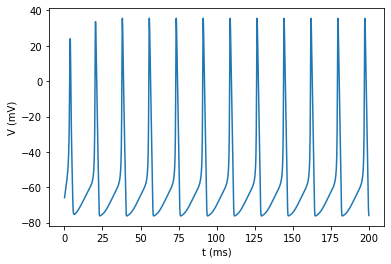

In [8]:
runner.run(200)  # the running time is 200 ms

import matplotlib.pyplot as plt

plt.plot(runner.mon['ts'], runner.mon['V'])
plt.xlabel('t (ms)')
plt.ylabel('V (mV)')

plt.show()

We can also visualize the changes of the gating variables of sodium and potassium channels:

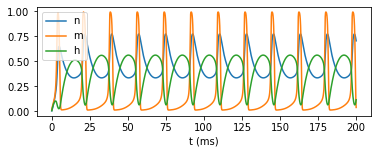

In [9]:
plt.figure(figsize=(6, 2))
plt.plot(runner.mon['ts'], runner.mon['IK.n'], label='n')
plt.plot(runner.mon['ts'], runner.mon['INa.p'], label='m')
plt.plot(runner.mon['ts'], runner.mon['INa.q'], label='h')
plt.xlabel('t (ms)')
plt.legend()

plt.show()

By combining different ion channels, we can get different types of conductance-based neuron models easily and straightforwardly. To see all predifined channel models in BrainPy, please click [here](../apis/dyn.rst).